# Trabalho de Implementação - Heurísticas e Metaheurísticas
## Thiago Pádua de Carvalho - 2020007066

### Código auxiliar

In [1]:
import os
import pandas as pd
import re
import subprocess
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Report:
    def __init__(self):
        self.df = pd.DataFrame(columns=["Instance", "Heuristic", "Time (s)", "Result"])


    def generate_report(self, instance_path, mode="NN"):
        heuristic = "Nearest Neighbor" if mode == "NN" else "VND"

        start_time = time.time()
        result = subprocess.run(['./heuristic', instance_path, mode], capture_output=True, text=True)
        end_time = time.time()
        elapsed_time = end_time - start_time

        instance_path = re.sub(r'\w+\/', "", instance_path)

        # Add new line to the dataframe
        self.df.loc[len(self.df)] = [instance_path, heuristic, elapsed_time, float(result.stdout.strip())]

        return self.df


    def average_time(self):
        average_df = self.df.groupby('Instance', as_index=False)['Time (s)'].mean()
        average_df.rename(columns={"Time (s)": "Average Time (s)"}, inplace=True)
        return average_df


    def average_results(self):
        average_df = self.df.groupby('Instance', as_index=False)['Result'].mean()
        average_df.rename(columns={"Result": "Average Result"}, inplace=True)
        return average_df


    def reset_report(self):
        self.df = pd.DataFrame(columns=["Instance", "Heuristic", "Time (s)", "Result"])


    def report(self, number_of_iterations = 100, mode="NN"):
        """
        Generate a report of the heuristic performance on the TSP instances
        Parameters:
        - number_of_iterations: number of times the heuristic will be run on each instance
        - mode: "NN" for Nearest Neighbor or "VND" for Variable Neighborhood Descent
        """
        directory = "instances/EUC_2D"

        for _ in range(number_of_iterations):
            for file in os.listdir(directory):
                filepath = os.path.join(directory, file)
                self.generate_report(filepath, mode)
            self.generate_report("instances/att48.tsp", mode)

        df_time = self.average_time()
        df_result = self.average_results()

        final_report = pd.merge(df_time, df_result, on="Instance")

        return final_report


In [3]:
report_NN = Report()
final_report_NN = report_NN.report(number_of_iterations=100, mode="NN")

In [5]:
report_VND = Report()
final_report_VND = report_VND.report(number_of_iterations=100, mode="VND")

In [52]:
optimal = [
    ["att48.tsp", 48, "ATT", 10628],
    ["berlin52.tsp", 52, "EUC_2D", 7542],
    ["kroA100.tsp", 100, "EUC_2D", 21282],
    ["kroA150.tsp", 150, "EUC_2D", 26524],
    ["kroA200.tsp", 200, "EUC_2D", 29368],
    ["kroB100.tsp", 100, "EUC_2D", 22141],
    ["kroB150.tsp", 150, "EUC_2D", 26130],
    ["kroB200.tsp", 200, "EUC_2D", 29437],
    ["kroC100.tsp", 100, "EUC_2D", 20749],
    ["kroD100.tsp", 100, "EUC_2D", 21294],
    ["kroE100.tsp", 100, "EUC_2D", 22068],
    ["lin105.tsp", 105, "EUC_2D", 14379],
    ["pr107.tsp", 107, "EUC_2D", 44303],
    ["pr124.tsp", 124, "EUC_2D", 59030],
    ["pr136.tsp", 136, "EUC_2D", 96772],
    ["pr144.tsp", 144, "EUC_2D", 58537],
    ["pr152.tsp", 152, "EUC_2D", 73682],
    ["pr76.tsp", 76, "EUC_2D", 108159],
    ["rat195.tsp", 195, "EUC_2D", 2323],
    ["rat99.tsp", 99, "EUC_2D", 1211],
    ["st70.tsp", 70, "EUC_2D", 675],
]

optimal_results = pd.DataFrame(optimal, columns=["Instance", "#cities", "Type", "Result"])

In [72]:
def plot_comparison(dataframes):
    """
    Plot a comparison between the results and times of the heuristics
    """
    methods = ["Nearest Neighbor", "Variable Neighborhood Descent"]  # TODO: Add third method

    for dataframe, method in zip(dataframes, methods):
        dataframe.rename(columns={"Average Time (s)": f"Average Time {method}", "Average Result": f"Average Result {method}"}, inplace=True)

    comparison_df = dataframes[0]
    for df in dataframes[1:]:
        comparison_df = pd.merge(comparison_df, df, on="Instance")

    plt.figure(figsize=(12, 6))
    for _, method in zip(dataframes, methods):
        plt.plot(comparison_df["Instance"], comparison_df[f"Average Result {method}"], label=f"Average Result {method}", marker="o")
    plt.plot(optimal_results["Instance"], optimal_results["Result"], label="Optimal Result", marker="o", color="green")
    plt.title("Comparação de Resultados Médios")
    plt.xlabel("Instance")
    plt.ylabel("Average Result")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for _, method in zip(dataframes, methods):
        plt.plot(comparison_df["Instance"], comparison_df[f"Average Time {method}"], label=f"Average Time {method}", marker="o")
    plt.title("Comparação de Tempos Médios")
    plt.xlabel("Instance")
    plt.ylabel("Average Time (s)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Heurística Construtiva - Nearest Neighbour
A heurística construtiva escolhida foi a Nearest Neighbour. Sua estratégia é simples e consegue atingir uma boa aproximação do valor ótimo de maneira relativamente eficiente. A ideia é começar em um vértice arbitrário e, a partir dele, escolher o mais próximo que ainda não foi visitado. O algoritmo termina quando um ciclo hamiltoniano com nós correspondentes a todas as cidades é completo. A complexidade é O(n²) no pior caso, onde n corresponde ao número de cidades (pontos).

### Implementação
Instâncias geométricas, onde as cidades correspondem a pontos no plano e a distância entre duas cidades depende de suas coordenadas apresentam a vantagem de possibilitar descartar rapidamente grandes grupos de arestas, aproveitando a geometria com estruturas de dados apropriadas.

#### **K-D Tree**
Em particular, para pontos no plano, é possível construir em tempo O(Nlog⁡N) uma estrutura de dados (ED) que permita responder a consultas de vizinhos mais próximos em tempo médio bem inferior a O(N) por consulta. A estrutura escolhida foi a k-d tree, com k = 2 dimensões.

Árvores desse tipo são similares a Binary Seach Trees. A diferença é que, em vez de comparar a chave de busca com a chave do nó atual, ela é comparada com a coordenada correspondente do nó atual. A cada nível da árvore, a dimensão da comparação é alternada. A árvore é construída recursivamente, de maneira que cada nó acrescentado divide o espaço em duas regiões menores, até que cada nó contenha um ponto. Desse modo, o número de operações necessárias para encontrar vizinhos mais próximos geralmente é em média O(log⁡N), quando a árvore á balanceada

![K-D Tree](images/KDtree.png)

Sendo assim, os passos da heurística são os seguintes:
```
1. Construir a k-d tree com as cidades
2. Inicializar o ciclo hamiltoniano com uma cidade arbitrária
3. Enquanto houver cidades não visitadas:
    4. Encontrar a cidade mais próxima da última cidade visitada
    5. Adicionar a cidade ao ciclo
    6. Remover a última cidade visitada da k-d tree
7. Adicionar a primeira cidade ao ciclo
```



### Análise dos Resultados
Observando a média nas métricas de tempo e qualidade do resultado para 100 execuções das instâncias disponíveis, a heurística apresentou um desempenho satisfatório. O tempo médio de execução não superou 10ms. Isso, contudo, não foi acompanhado de uma qualidade de resultado tão próxima das soluções ótimas.

Nearest Neighbour, portanto, se mostra como uma heurística rápida e sua aplicação pode ser interessante em problemas onde a qualidade da solução não é o fator mais importante ou a velocidade da execução é um fator crítico.

In [73]:
display(final_report_NN)

,Instance,Average Time Nearest Neighbor,Average Result Nearest Neighbor
0,att48.tsp,0.007087,46702.18000
1,berlin52.tsp,0.006970,9973.31000
2,kroA100.tsp,0.007284,36760.61900
3,kroA150.tsp,0.007531,41892.61500
4,kroA200.tsp,0.007716,46305.62700
5,kroB100.tsp,0.007393,35571.75100
6,kroB150.tsp,0.007585,40788.70700
7,kroB200.tsp,0.007758,47853.88600
8,kroC100.tsp,0.007136,33184.02500
9,kroD100.tsp,0.007250,33692.73800


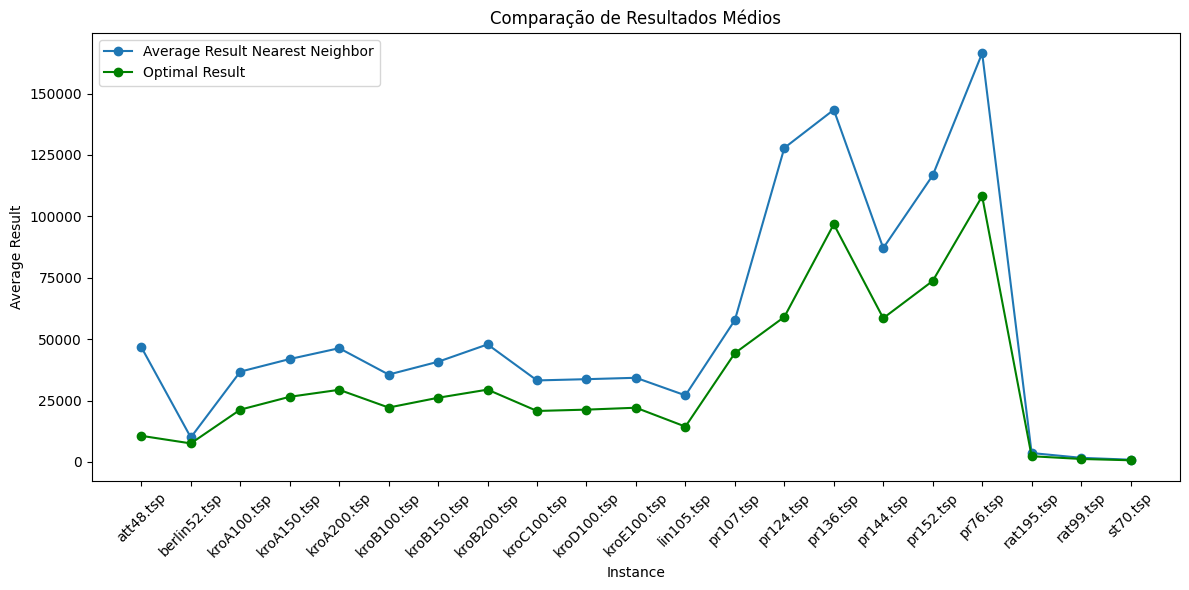

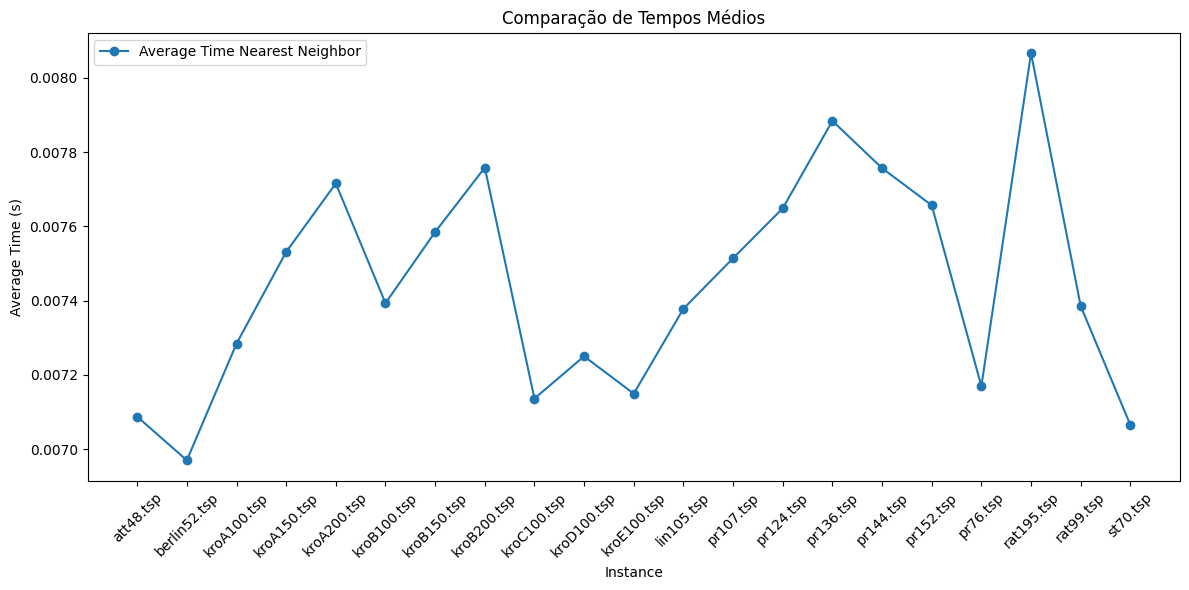

In [74]:
plot_comparison([final_report_NN])

## Variable Neighborhood Descent (VND)
O VND é uma metaheurística que explora múltiplas vizinhanças, as quais realizam buscas locais individualmente para escapar de ótimos locais e encontrar soluções melhores.

### Estrutura e Funcionamento
O VND é composto por uma solução inicial e um conjunto de vizinhanças. A execução é inciada por um caminho inicial - nesse caso o ciclo hamiltoniano gerado pela heurística construtiva de Nearest Neighbour - que é melhorado iterativamente.

As vizinhanças são dispostas em ordem crescente de complexidade, de modo que as mais custosas sejam menos frequentemente exploradas. A solução inicial é passada como parâmetro para a busca local da primeira vizinhança (N1), produzindo uma melhoria. Esse resultado é, então levado à vizinhança adiante.

N2 então realiza outra busca local. Caso a resultado seja melhorado, o processo é reiniciado a partir da primeira vizinhança. Caso contrário, a busca é realizada na próxima. O procedimento continua até que nenhuma melhoria seja encontrada em todas elas, indicando que a solução atual é localmente ótima para o conjunto de vizinhanças explorado.

### Implementação
#### Heurística Construtiva Inicial
Foi escolhida a heurística de Nearest Neighbour para gerar o ciclo hamiltoniano inicial. Suas vantagens são a simplicidade e eficiência, além de ser uma boa aproximação para o valor ótimo.

#### Vizinhanças
As vizinhanças escolhidas foram da família k-opt. Esta é uma classe de heurísticas para o Problema do Caixeiro Viajante (TSP) que visa melhorar uma solução inicial trocando k arestas por outras k arestas, reconectando as cidades de forma a reduzir a distância total do percurso.

k representa a granularidade da troca: quanto maior o valor de k, maior o espaço de busca explorado.
2-opt e o 3-opt foram as variantes escolhidas devido ao equilíbrio entre simplicidade e eficácia.
Heurísticas de k-opt são fundamentais em buscas locais e em meta-heurísticas como VND, devido à sua capacidade de escapar de ótimos locais mais restritos.

N1. **2-opt**:\
A heurística 2-opt tenta resolver o problema de intersecção de arestas no percurso. Ela Busca duas arestas que cruzam entre si e as troca por duas novas arestas que eliminam o cruzamento. Isso é feito invertendo a ordem dos nós no segmento entre as arestas selecionadas.

Funcionamento:

1. Seleciona dois índices i e j = i + 2 no percurso, aproveitando a simetria para reduzir o espaço de busca pela metade.
2. Calcula o delta (diferença na distância total) causado pela troca.
3. Se a troca resultar em uma redução na distância, os nós entre ii e jj são invertidos.

Por questão de eficiência, foi implementada a modalidade de busca local First Improvement, que para a busca ao encontrar a primeira melhoria, ao invés de continuar a busca até o fim para cada iteração.

![2-Opt](images/2-opt.png)

N2. **3-opt**:\
A heurística 3-opt é uma extensão do 2-opt, que considera a troca de três arestas em vez de duas.

Gera mais possibilidades de reconexão do percurso ao remover três arestas e tentar reconectá-las de maneira mais eficiente.
Reduz ainda mais as interseções e explora mudanças mais complexas no percurso.

Funcionamento:

1. Seleciona três arestas, definindo segmentos do percurso.
2. Calcula as possíveis reconexões (8 no total) que podem ser feitas entre os segmentos.
3. Aplica a reconexão que reduz mais significativamente a distância total.

Complexidade:

O número de trocas possíveis é maior que no 2-opt, resultando em O(n³) verificações no pior caso.
Embora mais custoso, o 3-opt é mais poderoso para escapar de ótimos locais do que o 2-opt.

Como a complexidade do 3-opt é maior, ele é explorado apenas quando o 2-opt não encontra melhorias. Além disso, foi escolhida a modalidade Best Improvement, que explora todas as possibilidades de troca e escolhe a que resulta na maior redução da distância total para cada iteração.

![3-Opt](images/3-opt.png)

| Aspecto                  | **2-opt**            | **3-opt**            |
|--------------------------|----------------------|----------------------|
| Trocas                   | 2 arestas           | 3 arestas           |
| Complexidade Computacional | \( O(n²) \)        | \( O(n³) \)        |
| Exploração               | Limitada            | Mais abrangente     |
| Facilidade de Implementação | Alta                | Moderada            |
| Efetividade              | Boa                 | Excelente           |


### Análise dos Resultados
Verificando o contraste entre as soluções geradas pela heurística construtiva e a metaheurística VND, é possível observar claramente o trade-off entre tempo de execução e qualidade da solução. Enquanto Nearest Neighbour é muita rápida, seus resultados são piores para todas as instâncias do problema, especialmente para as maiores. O VND, por outro lado, é mais lento, porém consegue melhorar significativamente as soluções iniciais, atingindo valores mais próximos do ótimo.

In [75]:
display(final_report_VND)
final_report_VND.to_csv("VND_report.csv", index=False)

,Instance,Average Time Variable Neighborhood Descent,Average Result Variable Neighborhood Descent
0,att48.tsp,0.134846,33786.05000
1,berlin52.tsp,0.139536,7796.46990
2,kroA100.tsp,1.673963,21665.88200
3,kroA150.tsp,11.267395,27576.74000
4,kroA200.tsp,32.317969,30243.05600
5,kroB100.tsp,2.132092,22619.61900
6,kroB150.tsp,12.108032,26685.89500
7,kroB200.tsp,39.216280,30451.74400
8,kroC100.tsp,2.084641,21433.16600
9,kroD100.tsp,2.653021,21945.86000


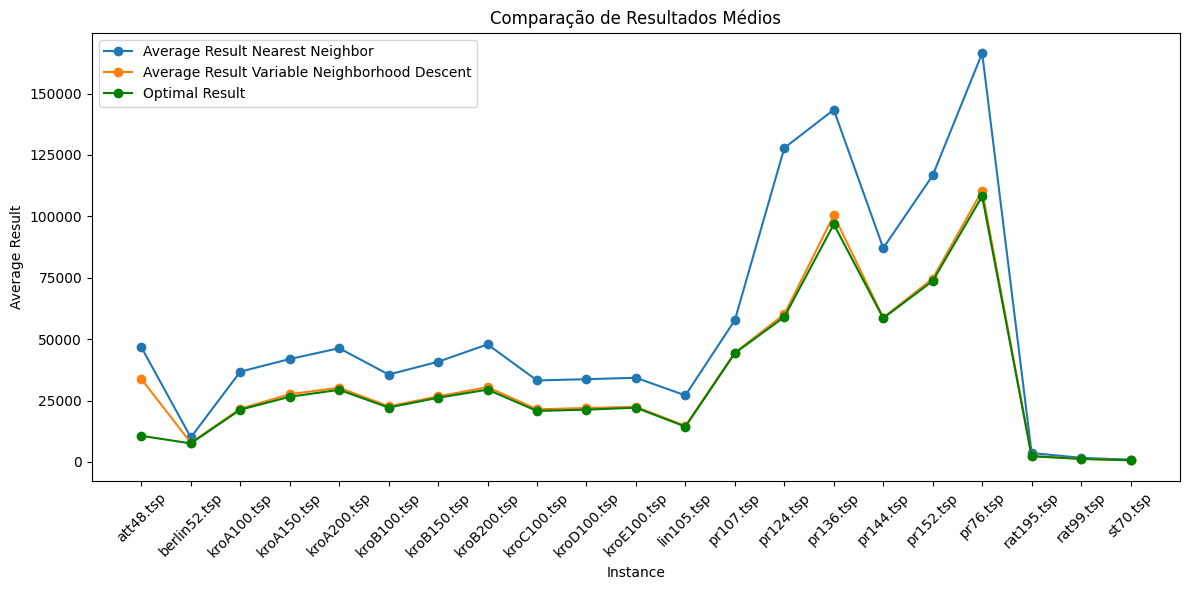

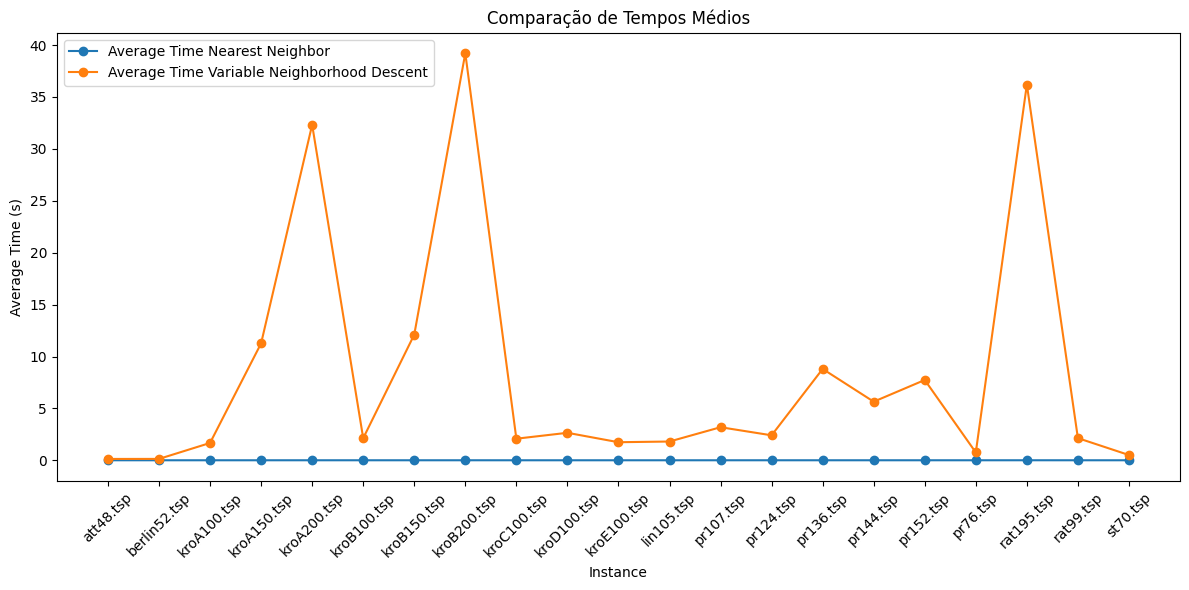

In [76]:
plot_comparison([final_report_NN, final_report_VND])

## Metaherística de Iterative Local Search (ILS)